# Прогнозирование вероятности оттока клиентов фитнес-клуба

`Заказчик`: Сеть фитнес-центров   

`Цель исследования`: спрогнозировать ооток клиентов и составить план действий по удержанию клиентов  

`Входные данные`: данные о пользователях и посещениях на месяц до оттока и факт оттока на определённый месяц

`Задачи`: 1) спрогнозировать вероятность оттока для каждого клиента; 2) сформировать типичные портреты пользователей: выделить несколько групп; 3) выделить признаки, наиболее сильно влияющие на отток; 4) разработать рекомендации по повышению качества работы с клиентами и предложить меры по снижению оттока.

<h1>Содержание проекта<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-пользователей" data-toc-modified-id="Построение-модели-прогнозирования-оттока-пользователей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Построение модели прогнозирования оттока пользователей</a></span></li><li><span><a href="#Кластеризация-пользователей" data-toc-modified-id="Кластеризация-пользователей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Кластеризация пользователей</a></span></li><li><span><a href="#Выводы-и-базовые-рекомендации-по-работе-с-клиентами" data-toc-modified-id="Выводы-и-базовые-рекомендации-по-работе-с-клиентами-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы и базовые рекомендации по работе с клиентами</a></span></li></ul></div>

## Исследовательский анализ данных (EDA)

Импортируем и при необходимости предобработаем данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

Уберем прокрутку вывода результатов ячейки

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Загрузим датасет

In [3]:
try:
    gym = pd.read_csv('/datasets/gym_churn.csv') #путь на я.практикум
except:
    gym = pd.read_csv('gym_churn.csv')  #если ошибка, мой локальный путь

In [4]:
gym.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
2264,0,1,1,0,1,1,0,29,58.358479,1.0,0,0.000000,0.000000,1
3572,0,1,1,1,1,1,0,29,207.464718,1.0,4,2.021520,1.768576,0
565,0,1,1,0,1,12,1,30,110.766716,12.0,1,2.203212,2.309613,0
2612,1,1,0,0,0,6,1,33,134.022392,6.0,10,2.077199,1.997620,0
2825,1,0,1,0,1,1,0,27,37.401690,1.0,3,2.108084,1.092014,1


**Описание данных**  
Каждая запись в логе — это данные об одном пользователе.  

Целевая переменная: `Churn` — факт оттока в текущем месяце (0/1)  

Бинарные признаки (0/1):  
`gender` — пол;  
`Near_Location` — проживание/работа рядом с фитнес-центром;  
`Partner` — сотрудник компании-партнёра клуба;  
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»;  
`Phone` — наличие контактного телефона;  
`Group_visits` — факт посещения групповых занятий;  

Количественные признаки:  
`Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
`Age` — возраст;  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;   
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;   

In [5]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропущенных значений нет, заменим формат столбца с количеством месяцев до окончания действия абонемента на целочисленный. Остальные стобцы в корректных форматах.

In [6]:
gym['Month_to_end_contract'] = gym['Month_to_end_contract'].astype('int')

Проверим на наличие дубликатов

In [7]:
gym.duplicated().sum()

0

Изучим описательные статистики признаков

In [8]:
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


По минимальным и максимальным значениям признаков на первый взгляд аномалий нет.   
По гендерному признаку данные поделены почти поровну, также как и по статусу сотрудника компании-партнёра клуба.  
В данных преставлена возрастная группа клиентов от 18 до 41 лет. Что в принципе соответствует реальности.  
Большая доля клиентов из представленного датасета живет или работает рядом с клубом, почти все клиенты оставили свои контактные номера телефонов. Все клиенты имеют доп расходы в клубе. 

Изучим средние значения признаков с разбивкой на две группы — тех, кто ушел в отток и тех, кто остался, а также построим и изучим столбчатые гистограммы и распределения признаков.

In [9]:
gym.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [10]:
def feature_distplot(df1, df2):
    for feature in df1.columns:
        plt.figure(figsize=(10, 6))
        sns.distplot(df1[feature], color='#2E8B57', label='не отток') 
        sns.distplot(df2[feature], color='#FFA07A', label='отток') 
        plt.xlabel(feature)
        plt.ylabel('Частота')
        plt.title('Распределение ' + feature)
        plt.legend()
        plt.show()

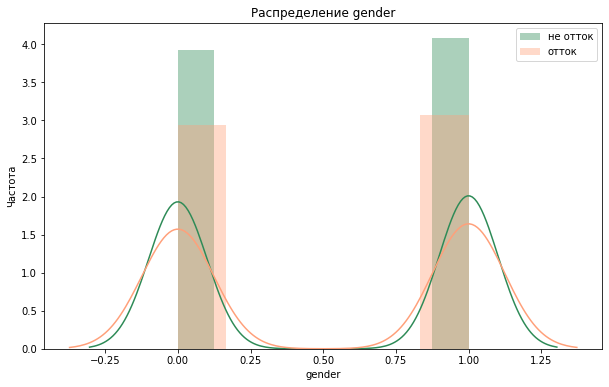

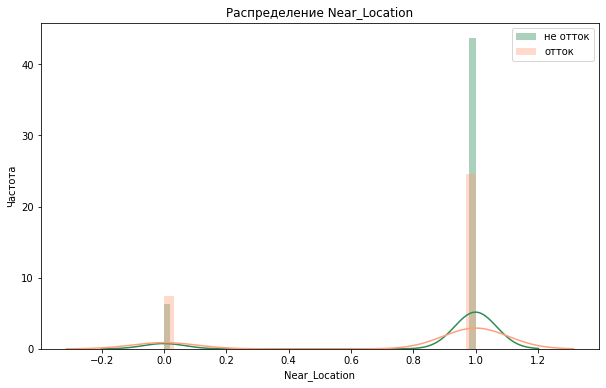

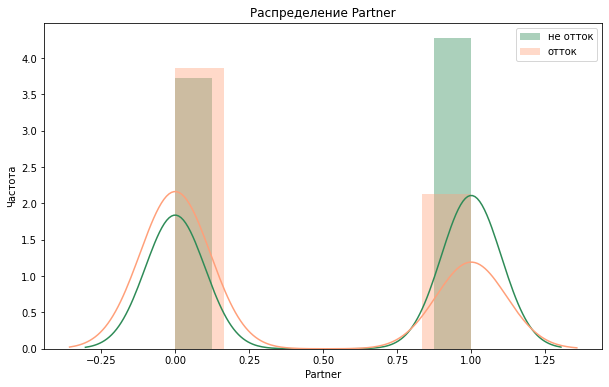

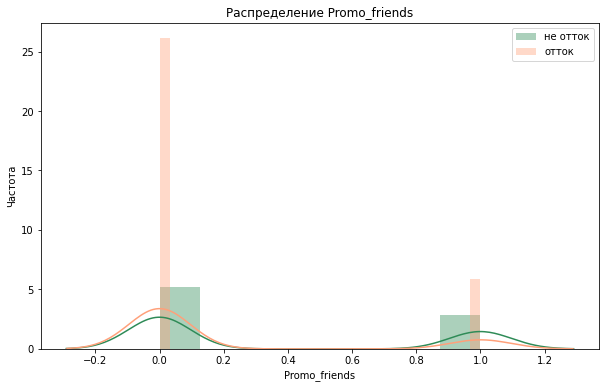

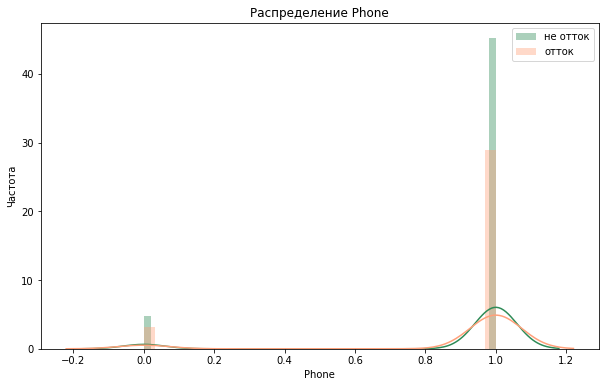

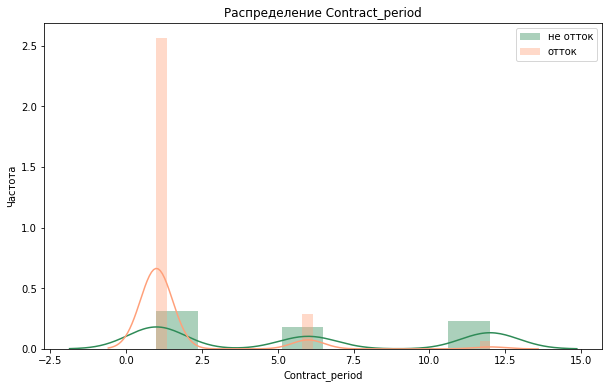

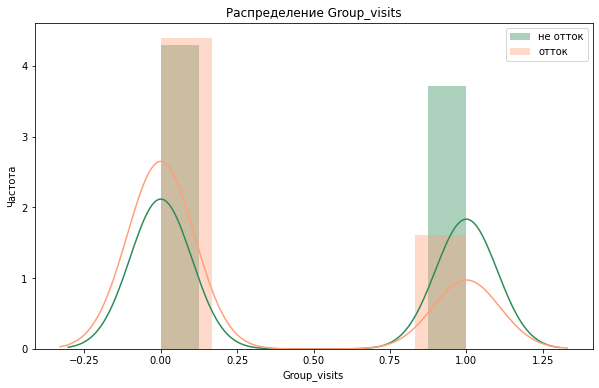

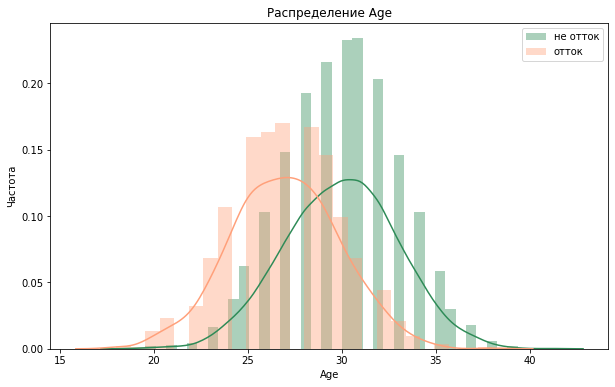

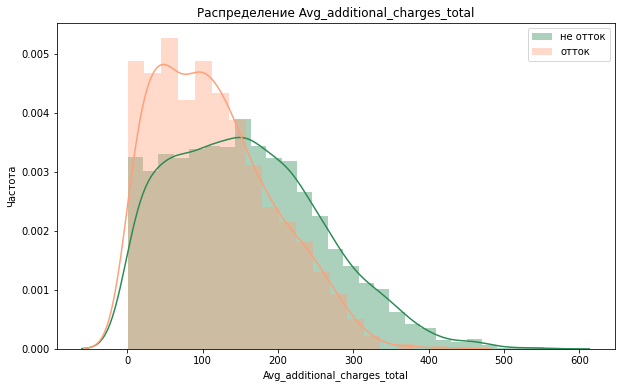

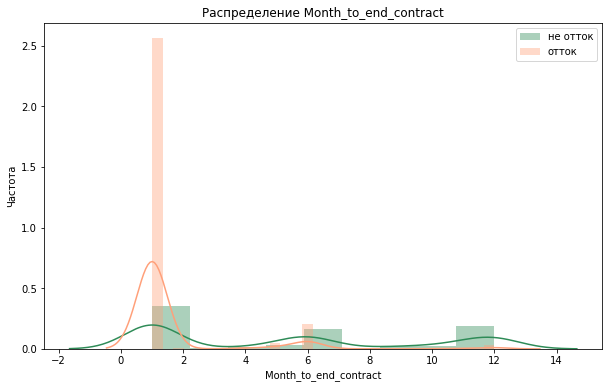

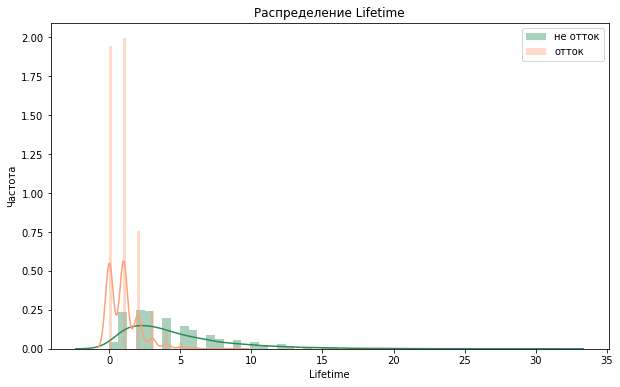

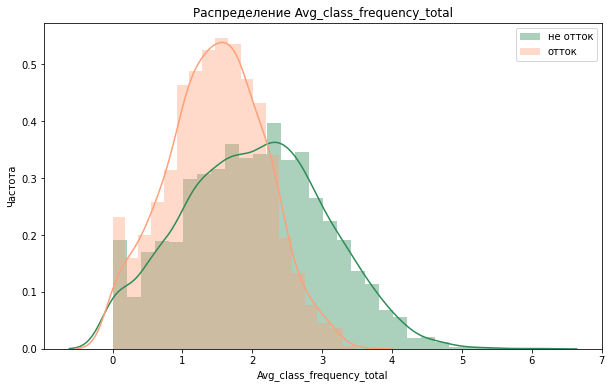

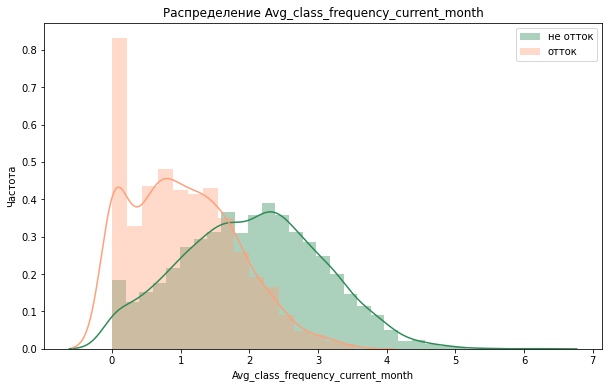

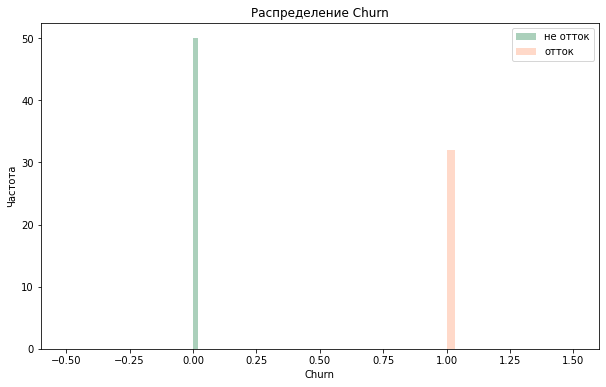

In [11]:
feature_distplot(gym.query('Churn == 0'), gym.query('Churn == 1'))

По средним значениям признаков и распределениям признаков можно отметить, что:  
По гендерному признаку отличий в оттоке особо не наблюдается.  
Среди ушедших в отток клиентов, выше доля тех, кто не живет/работает рядом с клубой, а также выше доля тех, кто не является сотрудником компании-партнёра клуба.   
Тех, кого привели друзья, с большей вероятностью остаются в клубе.
В отток уходят клиенты, оформляющие абонементы на короткие сроки и реже посещающие групповые программы.  
Средний возраст клиентов, ушедших в отток ниже, чем у оставшихся в клубе, т.е. в отток уходят более молодые клиенты.  
Ушедшие в отток имели меньшие дополнительные затраты в клубе. Большая доля клиентов уходит в отток в первый месяц и реже посещает занятия. 

Построим и изучим матрицу корреляций признаков

<AxesSubplot:>

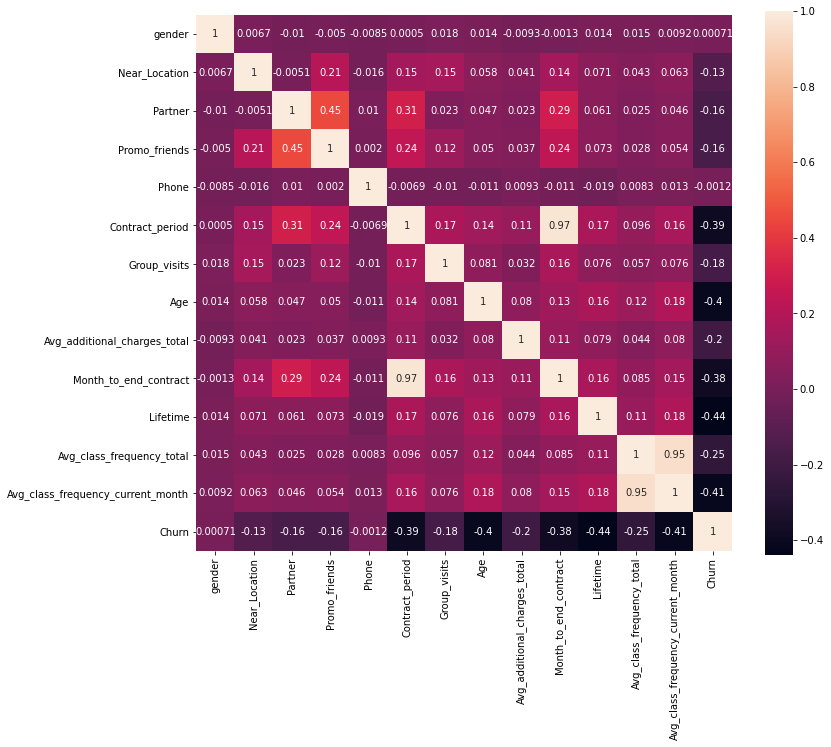

In [12]:
cm = gym.corr() 
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot = True, square=True)

Справедливо высокая корреляция между признаками "длительность текущего действующего абонемента" и `"срок до окончания текущего действующего абонемента"`, а также между признаками "средняя частота посещений в неделю за все время с начала действия абонемента" и `"средняя частота посещений в неделю за предыдущий месяц"`.  
С целевой переменной "факт оттока" наиболее сильно коррелируют "время с момента первого обращения в фитнес-центр", "возраст клиента", "средняя частота посещений в неделю за предыдущий месяц", "длительность текущего действующего абонемента", "срок до окончания текущего действующего абонемента".

**Вывод**  
Исследовательский анализ данных проведен, составлено предварительное представление о клиентах клуба и признаках, влияющих на их отток из фитнес-клуба. 

In [13]:
gym2 = gym.copy()

In [14]:
gym2 = gym2.drop(columns=['Month_to_end_contract', 'Avg_class_frequency_current_month'])

## Построение модели прогнозирования оттока пользователей

 Целевой признак — факт оттока пользователя в следующем месяце.

In [15]:
X = gym.drop(columns=['Churn'])
y = gym['Churn']

Разделим модель на обучающую и валидационную выборки

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Добавила 

Зададим список моделей, при помощи которых будем прогнозировать отток клиентов: логистическая регрессия и случайный лес

In [17]:
models = [
    LogisticRegression(
        solver='liblinear',
        random_state=0
    ),
    RandomForestClassifier(
        n_estimators = 100,
        random_state = 0
    ),
]

Создадим функцию, применяющую алгоритм модели из списка для решения задачи бинарной классификации - прогнозирования оттока клиента, а также рассчитывающую метрики accuracy, precision и recall для моделей из списка на валидационной выборке.

In [18]:
def predictions_maker(m, X_train, X_test, y_train, y_test):
    model = m
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)
    print(
        'accuracy:{:.2f}, precision:{:.2f}, recall:{:.2f} '.format(accuracy, precision, recall)
    )
    print('F1: {:.2f}, ROC_AUC: {:.2f}'.format(f1, roc_auc))

In [19]:
for i in models:
    print(i)
    predictions_maker(i, X_train, X_test, y_train, y_test)
    print('==============================================')

LogisticRegression(random_state=0, solver='liblinear')
accuracy:0.93, precision:0.89, recall:0.83 
F1: 0.86, ROC_AUC: 0.98
RandomForestClassifier(random_state=0)
accuracy:0.92, precision:0.88, recall:0.83 
F1: 0.85, ROC_AUC: 0.97


**Вывод**  
Метрики модели логистическая регрессия выше, соответственно, можно сделать вывод, что данная модель в прогнозе оттока клиента покажет себя лучше.

In [20]:
X2 = gym2.drop(columns=['Churn'])
y2 = gym2['Churn']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0, stratify=y2)
for i in models:
    print(i)
    predictions_maker(i, X_train2, X_test2, y_train2, y_test2)
    print('==============================================')

LogisticRegression(random_state=0, solver='liblinear')
accuracy:0.90, precision:0.83, recall:0.80 
F1: 0.81, ROC_AUC: 0.96
RandomForestClassifier(random_state=0)
accuracy:0.89, precision:0.81, recall:0.79 
F1: 0.80, ROC_AUC: 0.95


## Кластеризация пользователей

Проведем кластеризацию пользователей.   

Стандартизируем данные

In [21]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Построим матрицу расстояний на стандартизованной матрице признаков

In [22]:
linked = linkage(X_st, method = 'ward')

Построим дендрограмму

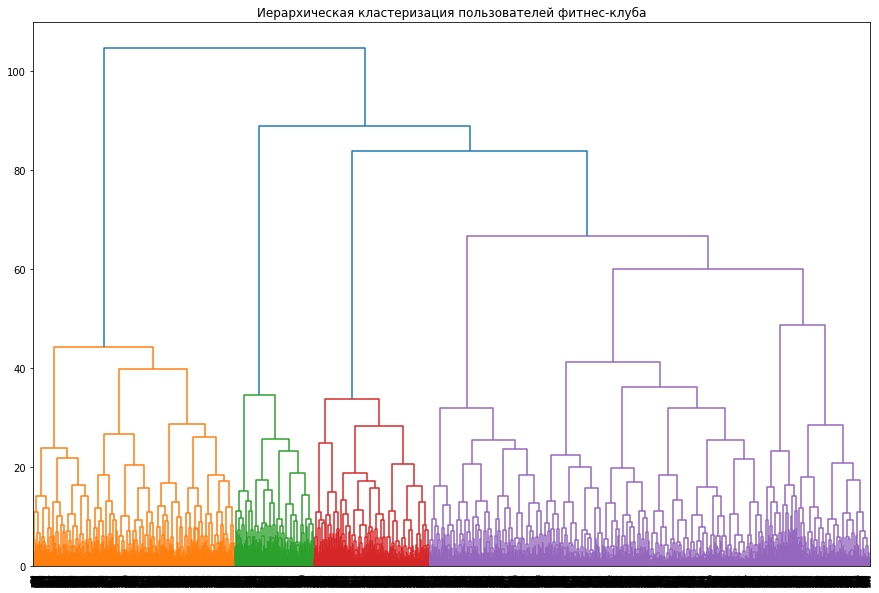

In [23]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей фитнес-клуба')
plt.show()

На основании полученной дендрограммы можно предположить, что клиентов стоит разделить на 6 кластеров.
По условию задания разделим клиентов на 5 кластеров.  
Спрогнозируем кластеры клиентов с помощью модели кластеризации на основании алгоритма K-Means.

In [24]:
km = KMeans(n_clusters = 5, random_state=0)

In [25]:
labels = km.fit_predict(X_st)

Добавим отнесение к кластеру в отдельный столбец датасета

In [26]:
X['cluster'] = labels

In [27]:
X.sample(3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,cluster
3469,0,1,0,0,1,6,0,31,5.145096,6,6,1.937720,2.009899,4
1349,1,0,1,0,1,1,0,29,5.799498,1,6,2.282678,2.414892,2
178,1,1,0,1,1,1,1,29,95.661558,1,1,2.179250,0.942722,3


Изучим средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [28]:
X.groupby('cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161


Судя по средним значениям признаков в разрезе кластеров можно отметить:
1) по гендерному признаку кластеры распределились достаточно равномерно;
2) больших отличий в среднем возрасте между кластерами также не наблюдается;
3) в остальных признаках видим отличия между кластерами

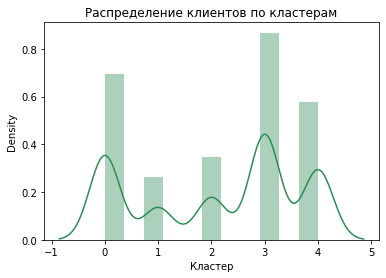

In [29]:
sns.distplot(X['cluster'], color='#2E8B57')
plt.xlabel('Кластер')
plt.title('Распределение клиентов по кластерам')
plt.show()

К классу 3 отнесено больше всего пользователей, в классе 0 также отказалось довольно много пользователей. Меньше всего пользователей попало в класс 1 и класс 2.

Посмотрим на отличия бинарных признаков по кластерам:

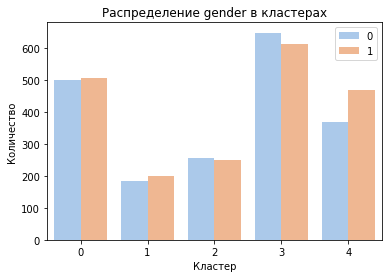

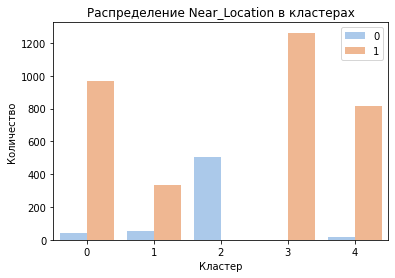

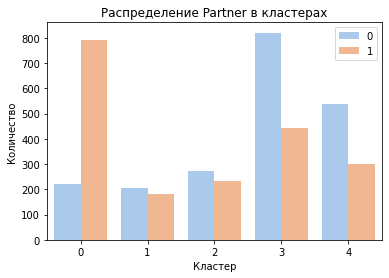

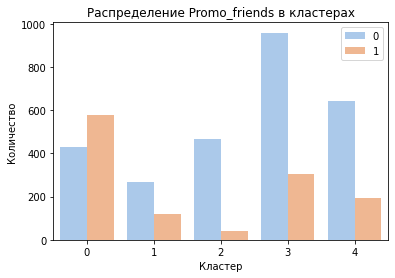

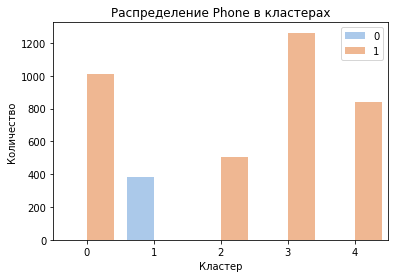

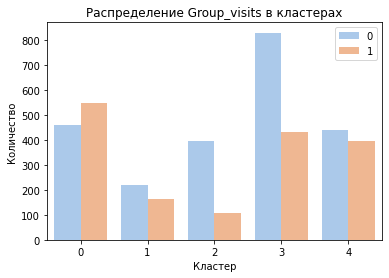

In [30]:
features_bi = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']
for feature in features_bi:
    sns.countplot(data=X, x='cluster', hue=feature, palette='pastel')
    plt.xlabel('Кластер')
    plt.ylabel('Количество')
    plt.title('Распределение ' + feature + ' в кластерах')
    plt.legend()
    plt.show()

Отличие по гендерному признаку просматривается только в кластере 4.  
По удаленности от места проживания/работы клиента кластеры разделились довольно четко на проживающих\работающих рядом и нет. В кластере 2 те, кто живут и работают далеко от клуба.  
По факту трудоустройтсва клиента в компании-партнере клуба в двух кластерах (1,2) почти нет отличий, в кластере 0 значительно преобладают сотрудники, в кластерах 3,4 больше тех, кто не является сотрудниками.   
По факту первоначальной записи в рамках акции «приведи друга» клиенты распределились хаотично. Кластер 0 выделяется среди других преобладанием клиентов, записавшихся по акции.  
По наличию контактного телефона клиенты четко разделились на 4 кластера с наличием контактного телефона и  кластер 1 - без контактного телефона.  
По факту посещения групповых занятий в кластерах 2 и 3 значительное преобладание одной тех, кто не посещает.

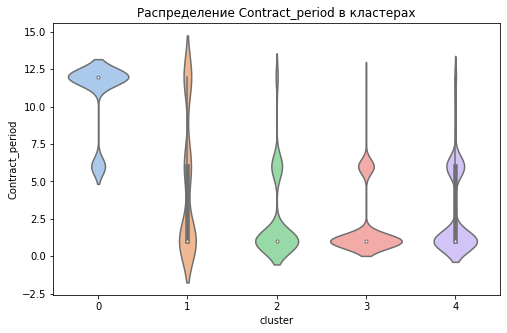

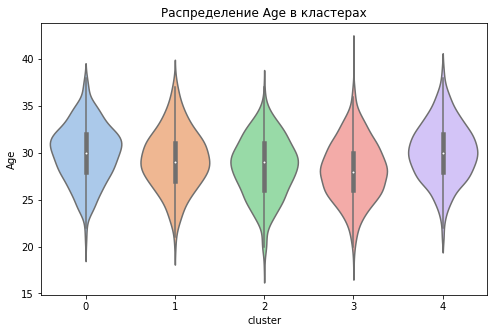

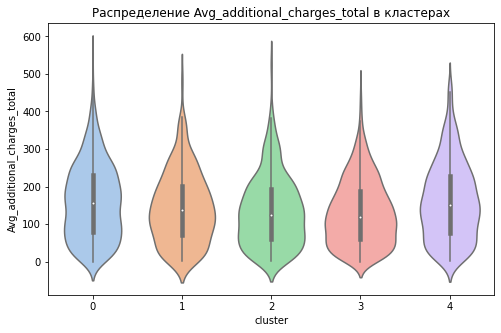

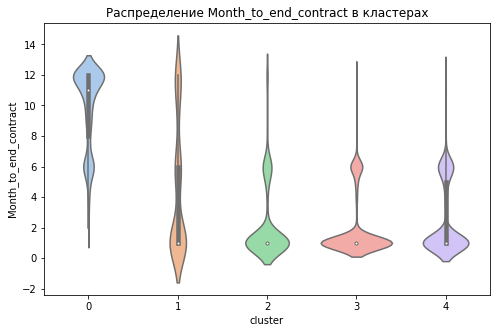

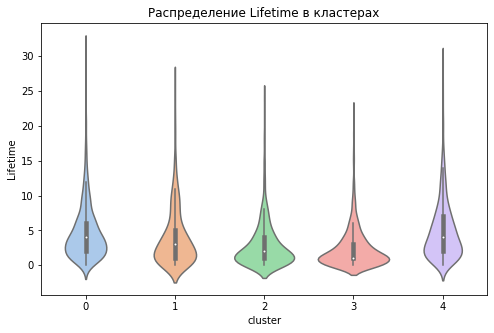

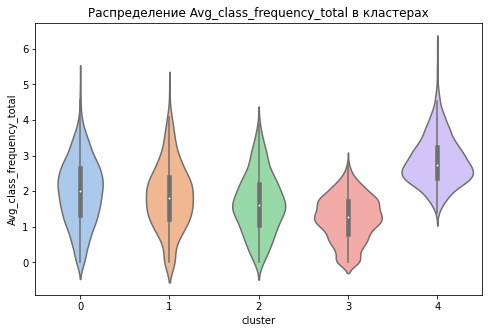

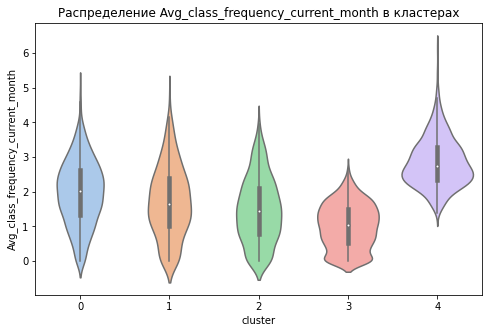

In [31]:
features = [
    'Contract_period', 
    'Age', 
    'Avg_additional_charges_total', 
    'Month_to_end_contract', 
    'Lifetime', 
    'Avg_class_frequency_total',
    'Avg_class_frequency_current_month'
]

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='cluster', y=feature, data=X, orient='v', palette='pastel')
    plt.title('Распределение ' + feature + ' в кластерах')

По длительности абонемента в кластер 0 попали в основном клиенты с годовым абонементом, и небольшая доле с полугодовым, клиенты с одномесячными и трехмесячными абонементами не попали в этот кластер совсем. В кластере 1 есть все сроки абонементов.  
Кластеры 2,3,4 похожи, в них попали в основном клиенты с краткосрочными одномесячеыми абонементами, и небольшая доля клиентов с полугодовыми абонементами.  
По возрасту заметных отличий по кластерам не наблюдается.   
Дополнительные затраты кластерах примерно на одном уровне, в кластерах 0 и 4 чуть выше дургих.  
По количеству месяцев до конца абонемента распределения по кластерам похожи на длительность абонемента. В кластере 0 клиенты, у которых более полугода до окончания абонемента, в кластере 1 есть клиенты с разными сроками до конца абонемента, в кластерах 2,3,4 сроки окончания абонементов до полугода.  
В кластере 3 клиенты, которые недолго являются клиентами клуба. Самые лояльные клиенты в кластере 0 и 4.  
Наиболее часто посещающие клуб клиенты попали в кластер 4, наиболее редко посещающие - в кластер 3. 

Посчитаем долю оттока для каждого полученного кластера и посмотрим на отличия между кластерами

In [32]:
gym_clusters = X.join(y)

In [33]:
cluster_churn = (gym_clusters.groupby('cluster')['Churn'].sum() / gym_clusters.groupby('cluster')['Churn'].count()).reset_index()
cluster_churn.columns = ['cluster', 'churn']
cluster_churn = cluster_churn.sort_values(by='churn')
cluster_churn

,cluster,churn
0,0,0.027723
4,4,0.068019
1,1,0.267532
2,2,0.443564
3,3,0.514263


Text(0.5, 1.0, 'Доля оттока пользователей в кластерах')

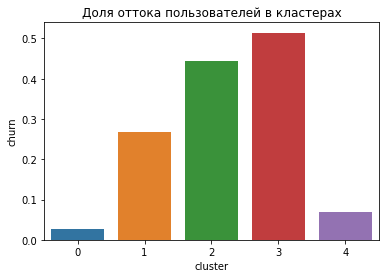

In [34]:
sns.barplot(data=cluster_churn, x='cluster', y='churn')
plt.title('Доля оттока пользователей в кластерах')

Максимальный отток характерен для кластера 3, в кластере 2 также высокая доля оттока. Средние показатели оттока у кластера 1. Наиболее надежными являются кластеры 0 и 4 с низкими долями оттока. 

## Выводы и базовые рекомендации по работе с клиентами

Наиболее надежными являются кластеры 0 и 4 с низкими долями оттока. Для этих кластеров характерны более высокие доп.расходы в клубе, абонементы на длительный срок, более частое посещение клуба. 
Наиболее высокая доля оттока в кластарах 3 и 2, для которых характерно надавнее пользование услугами клуба, редкие посещения, проживание и работа далеко от клуба, не посещения групповых программ.  

Соответственно, для удержания клиентов в клубе следует стимулировать более частое посещение клуба клиентом, делать упор на продажи абонементов на длительные сроки, повышать посещаемость групповых программ и вовлекать клиента в пользование дополнительными платными услугами клуба.  
Акцент следует делать на аудитории, проживающией/работающией рядом с клубом.  
Существующие в клубе акции эффективны: сотрудники компаний-партнеров и клиенты, приведенные друзьями по акции, с большей долей вероятности остаются клиентами клуба.